- Author: Peter Riesebos
- Purpose: Comparing overlapping eQTLs between pub rna and GTEx
- Input: summary stat files of both datasets
- Output: graphs, statistics

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import logging
import multiprocessing
import dask.dataframe as dd
import matplotlib.pyplot as plt

gtex eqtls location: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/fastqtl_eqtls

In [7]:
# Configure logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.StreamHandler()])

# Function to create a unique ID for comparison
def create_unique_id(gene):
    return gene.split('.')[0]  # Strip version from the gene

# Function to process each chromosome dataframe
def process_chr_df(chr_df):
    # Split variant_id and create necessary columns
    split_columns = chr_df['variant_id'].str.split('_', expand=True)
    chr_df['alleles'] = split_columns[2] + '/' + split_columns[3]
    chr_df['phenotype_id'] = chr_df['phenotype_id'].str.split('.').str[0]
    chr_df['SNPPos'] = pd.to_numeric(split_columns[1])
    chr_df['chrom'] = pd.to_numeric(split_columns[0].str.replace('chr', ''))
    
    return chr_df

# Function to compare and merge files, including flipped alleles
def compare_files(chromosome_file, mbqtl):
    logging.info(f"Processing file: {chromosome_file}")
    
    # Load chromosome data
    chr_df = pd.read_csv(chromosome_file, sep="\t")
    chr_df = process_chr_df(chr_df)
    
    # Create UniqueIDs for mbqtl DataFrame
    mbqtl['UniqueID'] = mbqtl['Gene'].apply(create_unique_id)

    # Prepare for merging
    merged_dfs = []

    # Merge with original alleles
    merged_df = pd.merge(
        mbqtl, chr_df, 
        how='inner', 
        left_on=["UniqueID", "SNPPos", "GeneChr", "SNPAlleles"], 
        right_on=["phenotype_id", "SNPPos", "chrom", "alleles"]
    )
    merged_dfs.append(merged_df)

    # Prepare for flipped alleles
    chr_df['flipped_alleles'] = chr_df['alleles'].apply(lambda x: '/'.join(x.split('/')[::-1]))  # Flip alleles
    merged_flipped_df = pd.merge(
        mbqtl, chr_df,
        how='inner',
        left_on=["UniqueID", "SNPPos", "GeneChr", "SNPAlleles"], 
        right_on=["phenotype_id", "SNPPos", "chrom", "flipped_alleles"]
    )
    merged_dfs.append(merged_flipped_df)

    # Concatenate all merged dataframes for this chromosome
    return pd.concat(merged_dfs, ignore_index=True) if merged_dfs else pd.DataFrame()

# Function to process chromosome files in parallel
def process_chromosome_files(mbqtl_file, chromosome_dir, output_file):
    logging.info(f"Starting to process combined file: {mbqtl_file}")

    # Read in the mbqtl DataFrame
    mbqtl = pd.read_csv(mbqtl_file, sep="\t")
    mbqtl['SNPPos'] = pd.to_numeric(mbqtl['SNPPos'])
    mbqtl['GeneChr'] = pd.to_numeric(mbqtl['GeneChr'])

    # Get chromosome files to process
    chromosome_files = [f for f in os.listdir(chromosome_dir) if f.endswith('.txt.gz')]
    chromosome_files = [os.path.join(chromosome_dir, f) for f in chromosome_files]  # Get full paths
    
    if not chromosome_files:
        logging.warning(f"No files to process in directory: {chromosome_dir}")
        return
    
    # Use multiprocessing to compare files in parallel
    logging.info(f"Processing {len(chromosome_files)} chromosome files in parallel.")
    with multiprocessing.Pool() as pool:
        results = pool.starmap(compare_files, [(file, mbqtl.copy()) for file in chromosome_files])

    # Combine all merged dataframes and save to output
    final_merged_df = pd.concat(results, ignore_index=True)
    final_merged_df.to_csv(output_file, sep='\t', index=False)

    logging.info("Finished processing all chromosome files.")

# Example usage
# process_chromosome_files('/path/to/mbqtl_file.txt', '/path/to/chromosome_dir', '/path/to/output_file.txt')


In [8]:
gtex_top = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_no_version/merged_topeffects_final.txt'
gtex_all = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/fastqtl_eqtls/colon_transverse'
output_file = '/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/gtex_mbqtl_gtex_fastqtl_comparison.txt'

# Process all chromosome files and merge into one output
process_chromosome_files(gtex_top, gtex_all, output_file)

2024-09-30 12:52:07,526 - INFO - Starting to process combined file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/mbqtl_output_gtex_no_version/merged_topeffects_final.txt
2024-09-30 12:52:07,611 - INFO - Processing 21 chromosome files in parallel.
2024-09-30 12:52:08,236 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/fastqtl_eqtls/colon_transverse/Colon_Transverse.v8.EUR.allpairs.chr5.txt.gz
2024-09-30 12:52:08,249 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/fastqtl_eqtls/colon_transverse/Colon_Transverse.v8.EUR.allpairs.chr2.txt.gz
2024-09-30 12:52:08,257 - INFO - Processing file: /groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/GTEx/fastqtl_eqtls/colon_transverse/Colon_Transverse.v8.EUR.allpairs.chr17.txt.gz
2024-09-30 12:52:08,284 - INFO - Processing file: /groups/umcg-

In [2]:
df = pd.read_csv("/groups/umcg-fg/tmp04/projects/gut-bulk/ongoing/2024-02-07-GutPublicRNASeq/datasets/intersect/gtex_pub_rna_comparison.txt", sep="\t")
df.sort_values(by="GeneChr")

,Gene,GeneChr,GenePos,GeneStrand,GeneSymbol,SNP,SNPChr,SNPPos,SNPAlleles,SNPEffectAllele,...,maf,ma_samples,ma_count,pval_nominal,slope,slope_se,__index_level_0__,alleles,chrom,flipped_alleles
2821,ENSG00000263956,1,148102047,-,ENSG00000263956,rs61812034,1,148158692,G/A,A,...,0.142857,76,84,6.409398e-18,-0.514427,0.055002,3498,G/A,1,NaN
2822,ENSG00000196189,1,156147366,+,ENSG00000196189,rs372266718,1,156179474,T/C,C,...,0.397959,189,234,3.488837e-13,0.271668,0.035260,1391,T/C,1,NaN
2823,ENSG00000173409,1,230978981,+,ENSG00000173409,rs11122161,1,230956434,G/A,A,...,0.346939,165,204,3.263890e-15,-0.230511,0.027341,3855,G/A,1,NaN
2824,ENSG00000134375,1,201955503,+,ENSG00000134375,rs7513,1,201969867,C/T,T,...,0.486395,217,286,2.231385e-16,0.214162,0.024245,3354,C/T,1,NaN
2825,ENSG00000117528,1,94418389,+,ENSG00000117528,rs698951,1,94517647,C/T,T,...,0.222789,119,131,1.947828e-10,0.179401,0.026968,2891,C/T,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,ENSG00000186866,21,45263928,-,ENSG00000186866,rs2255761,21,45263707,A/G,G,...,0.318027,156,187,6.512422e-03,0.118930,0.043328,3918,A/G,21,NaN
1148,ENSG00000157617,21,41885112,-,ENSG00000157617,rs3746906,21,41907747,A/G,G,...,0.374150,184,220,4.218475e-04,-0.095069,0.026584,4087,A/G,21,NaN
1124,ENSG00000160188,21,42472486,-,ENSG00000160188,rs10084614,21,42468243,G/A,A,...,0.477891,226,281,4.777654e-06,-0.181330,0.038734,4746,G/A,21,NaN
1116,ENSG00000183844,21,41304212,+,ENSG00000183844,rs2838014,21,41325787,C/G,G,...,0.149660,82,88,1.378971e-08,0.564506,0.096017,3965,C/G,21,NaN


In [7]:
df.columns

Index(['Gene', 'GeneChr', 'GenePos', 'GeneStrand', 'GeneSymbol', 'SNP',
       'SNPChr', 'SNPPos', 'SNPAlleles', 'SNPEffectAllele',
       'SNPEffectAlleleFreq', 'QTLType', 'MetaP', 'MetaPN', 'MetaPZ',
       'MetaBeta', 'MetaSE', 'MetaI2', 'NrDatasets',
       'DatasetCorrelationCoefficients.GTEx_Colon_Transverse.GTEx_Small_Intestine.',
       'DatasetZScores.GTEx_Colon_Transverse.GTEx_Small_Intestine.',
       'DatasetSampleSizes.GTEx_Colon_Transverse.GTEx_Small_Intestine.',
       'NrTestedSNPs', 'ProportionBetterPermPvals', 'BetaDistAlpha',
       'BetaDistBeta', 'BetaAdjustedMetaP', 'PvalueNominalThreshold', 'qval',
       'UniqueID', 'phenotype_id', 'variant_id', 'tss_distance', 'maf',
       'ma_samples', 'ma_count', 'pval_nominal', 'slope', 'slope_se',
       '__index_level_0__', 'alleles', 'chrom', 'flipped_alleles'],
      dtype='object')

In [3]:
correlation = df["slope"].corr(df["MetaBeta"])

print(correlation)

0.9261788362923098


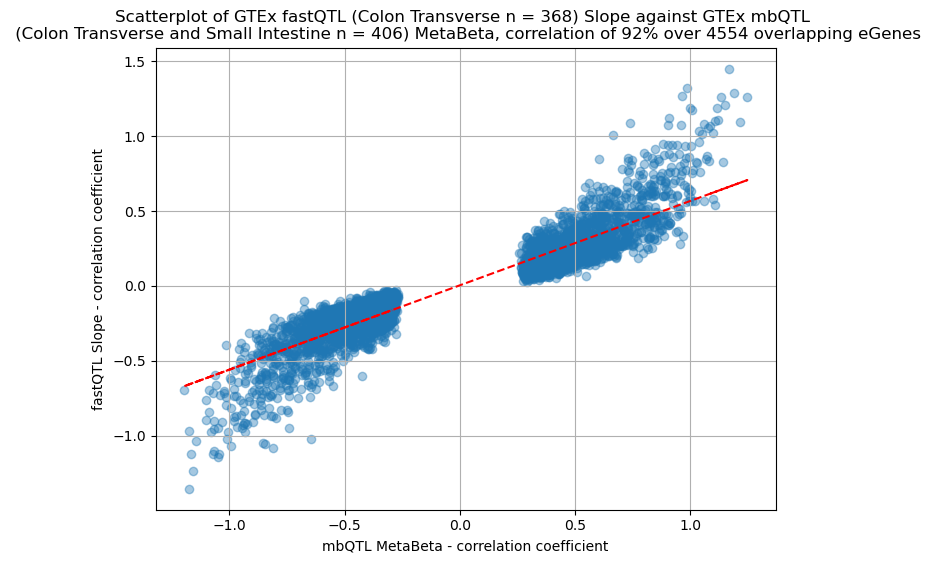

In [17]:
plt.figure(figsize=(8, 6), facecolor='white')

# Add trendline
z = np.polyfit(df["MetaBeta"], df["slope"], 1)  # Fit linear regression (1st-degree polynomial)
p = np.poly1d(z)
plt.plot(df["MetaBeta"], p(df["MetaBeta"]), "r--")  # Plot the trendline in red dashed style

plt.scatter(df["MetaBeta"], df["slope"], alpha=0.4)
plt.title("Scatterplot of GTEx fastQTL (Colon Transverse n = 368) Slope against GTEx mbQTL \n (Colon Transverse and Small Intestine n = 406) MetaBeta, correlation of 92% over 4554 overlapping eGenes")
plt.xlabel("mbQTL MetaBeta - correlation coefficient")
plt.ylabel("fastQTL Slope - correlation coefficient")
plt.grid()
plt.show()
